<a href="https://colab.research.google.com/github/mynuuuu/Oil-Spill-Detection/blob/main/Oil_Spill.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import sys
if 'google.colab' in sys.modules:
  %tensorflow_version 2.x
import tensorflow as tf
print("Tensorflow version " + tf.__version__)
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Tensorflow version 2.12.0
Found GPU at: /device:GPU:0


In [ ]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
    tpu = None
    gpus = tf.config.experimental.list_logical_devices("GPU")

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
elif len(gpus) > 1: # multiple GPUs in one VM
    strategy = tf.distribute.MirroredStrategy(gpus)
    print('multi-gpu')
else: # default strategy that works on CPU and single GPU
    strategy = tf.distribute.get_strategy()
    print('single_gpu')

print("REPLICAS: ", strategy.num_replicas_in_sync)

single_gpu
REPLICAS:  1


In [ ]:
import random
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dropout, Lambda
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, ZeroPadding2D, UpSampling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import optimizers
from keras import backend as K

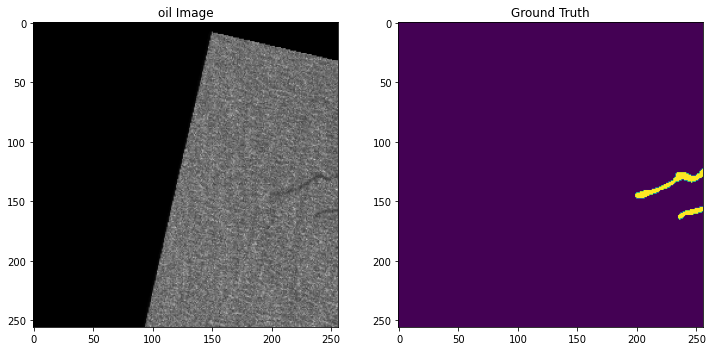

In [ ]:
img = cv2.imread('/content/drive/MyDrive/oil_detection (1)/train_images_256/041869.000003.tif')
mask = plt.imread('/content/drive/MyDrive/oil_detection (1)/train_masks_256/041869.000003.tif')
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,8))
ax1.imshow(img)
ax1.set_title("oil Image")
ax2.imshow(mask)
ax2.set_title("Ground Truth")
plt.show()

In [ ]:
#folder containing true images
img_path = '/content/drive/My Drive/oil_detection (1)/train_images_256/'

#folder containing mask images
masks_path = '/content/drive/My Drive/oil_detection (1)/train_masks_256/'


images = []
masks = []


for figname in os.listdir(img_path):
  images.append(cv2.cvtColor(cv2.imread(img_path + figname), cv2.COLOR_BGR2RGB))
  masks.append(plt.imread(masks_path + figname))

#convert images to numpy array format
images = np.array(images)
masks = np.array(masks)

#Print shape of Image and Mask arrays
print(images.shape)
print(masks.shape)

(790, 256, 256, 3)
(790, 256, 256)


In [ ]:
#Normalise pixels in image array by dividing by 255 so that pixel values range from 0-1
img_normal = (images / 255)

#Add one more axis to masks array to support image format
masks_process = (np.expand_dims(masks, -1) > 0).astype(np.float64)

#Split dataset into train,test and validation in the ration 8:1:1
X_train, X_test, y_train, y_test = train_test_split(img_normal, masks_process, test_size=0.2, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

#Print dataset shapes and sizes
print("Images Shape: ", img_normal.shape)
print("Masks Shape: ", masks_process.shape)

print("Training Samples: {}".format(len(y_train)))
print("Validation Samples: {}".format(len(y_val)))
print("Testing Samples: {}".format(len(y_test)))

Images Shape:  (790, 256, 256, 3)
Masks Shape:  (790, 256, 256, 1)
Training Samples: 632
Validation Samples: 79
Testing Samples: 79


In [ ]:
def iou_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou

def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)

    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

#Total loss
def total_loss(y_true, y_pred):
    return tf.keras.losses.binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

In [ ]:
with strategy.scope():

  inputs = Input((256, 256, 3))

  c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal',padding = 'same') (inputs)

  c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal',padding = 'same') (c1)

  m1 = MaxPooling2D((2, 2)) (c2)

  c3 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal',padding = 'same') (m1)

  u1 = UpSampling2D(size=(2, 2), interpolation='nearest') (c3)

  c4 = Conv2D(2, (5, 5), activation='relu', kernel_initializer='he_normal',padding = 'same') (u1)

  outputs = Conv2D(1, (1, 1), activation='sigmoid') (c4)

  model = Model(inputs=[inputs], outputs=[outputs])

  opt  = optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

  model.compile(optimizer=opt, loss=total_loss, metrics=[iou_coef,dice_coef,'acc'])

  print(model.summary())


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 32)      4640      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 32)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 16)      4624      
                                                                 
 up_sampling2d (UpSampling2D  (None, 256, 256, 16)     0         
 )                                                           

In [ ]:
earlystopper = EarlyStopping(patience=10, verbose=1)
checkpointer = ModelCheckpoint('model-fcnn.h5', monitor='val_loss', mode='auto', verbose=1, save_best_only=True)
results = model.fit(X_train, y_train, batch_size=8, epochs=100, validation_data=(X_val,y_val),
                    callbacks=[earlystopper, checkpointer])


Epoch 1/100
79/79 [==============================] - ETA: 0s - loss: 1.0907 - iou_coef: 0.0115 - dice_coef: 0.0304 - acc: 0.9822
Epoch 1: val_loss improved from inf to 1.05245, saving model to model-fcnn.h5
79/79 [==============================] - 12s 42ms/step - loss: 1.0907 - iou_coef: 0.0115 - dice_coef: 0.0304 - acc: 0.9822 - val_loss: 1.0524 - val_iou_coef: 0.0159 - val_dice_coef: 0.0447 - val_acc: 0.9804
Epoch 2/100
79/79 [==============================] - ETA: 0s - loss: 1.0386 - iou_coef: 0.0143 - dice_coef: 0.0433 - acc: 0.9822
Epoch 2: val_loss improved from 1.05245 to 1.04722, saving model to model-fcnn.h5
79/79 [==============================] - 3s 36ms/step - loss: 1.0386 - iou_coef: 0.0143 - dice_coef: 0.0433 - acc: 0.9822 - val_loss: 1.0472 - val_iou_coef: 0.0136 - val_dice_coef: 0.0414 - val_acc: 0.9804
Epoch 3/100
79/79 [==============================] - ETA: 0s - loss: 1.0172 - iou_coef: 0.0209 - dice_coef: 0.0657 - acc: 0.9819
Epoch 3: val_loss improved from 1.04722 

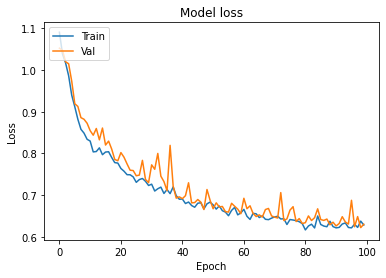

In [ ]:
# Plot training & validation loss curve
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()